# Creating the External Forcing Conditions

Name: Manh Tuong Nguyen

Date: 10/29/24

In this notebook, I describe the creation of the external forcing conditions I will use in my model.

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file and the initial conditions file generated in the previous notebooks for this model example.

In [12]:
# Mac
# input_dir = '/Users/eddie/cs185c_fall2024/project/input'

# Windows
input_dir = 'C:\\Users\\Eddie Nguyen\\Local Documents\\IcebergModeling\\Data'

## External Forcing Source Files
For my model, I will use the external forcing fields from the ECCO Version 5 state estimate. I will prepare these fields in 5 steps:
1. download 7 external forcing fields used in the ECCO model
2. read the external forcing fields used in the ECCO model as well as the ECCO grid
3. read in the bathymetry for my model as well as its grid
4. interpolate the ECCO fields onto my model grid and store each as a binary file
5. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO external forcing fields
To begin, I downloaded the ECCO external forcing fields used in the ECCO Version 5 Alpha state estimate. I use 2015 version of the files.
| Variable | File Name |
| -------- | --------- |
|ATEMP|EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl|
|SWDOWN|EIG_dsw_plus_ECCO_v4r1_ctrl|
|LWDOWN|EIG_dlw_plus_ECCO_v4r1_ctrl|
|UWIND|EIG_u10m|
|VWIND|EIG_v10m|
|PRECIP|EIG_rain_plus_ECCO_v4r1_ctrl|

I stored these fields in the following directory:

In [4]:
# Mac
# data_folder = '/Volumes/T7/data' 

#Windows
data_folder = "G:\\data"

### Step 2: Read in the external forcing fields
To read in the ECCO fields, I will rely on the `exf` module from the `eccoseas` package. I import them here:

In [5]:
import sys
# sys.path.insert(1,'/Users/mike/Documents/Research/Projects/Ocean_Modeling/Github Repositories')
from eccoseas.ecco import exf

Next, I will loop through all of the files I downloaded, reading them in with the `exf` module.

In [52]:
# make a file dictionary to loop over
file_prefix_dict = {
    'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
    'SWDOWN':'EIG_dsw_plus_ECCO_v4r1_ctrl',
    'LWDOWN':'EIG_dlw_plus_ECCO_v4r1_ctrl',
    'UWIND':'EIG_u10m',
    'VWIND':'EIG_v10m',
    # 'PRECIP':'EIG_rain_plus_ECCO_v4r1_ctrl'
}

# file_prefix_dict = {'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl'}
variable_names = list(file_prefix_dict.keys())

In [48]:
# make a list to hold all of the exf grid
exf_year = {}
exf_grids = []
years = range(1991, 1997, 1) # Then replace with 2017 and repeat the interpolation to create data for the 2017 model 

# loop through each variable to read in the grid
for year in years:
    for field in variable_names:
        exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(data_folder, file_prefix_dict[field], year)
        exf_grids.append(exf_grid)
    exf_year[year] = exf_grids

With an eye toward the interpolation that will come in step 4, I will make 2D grids of longitudes and latitudes to use in the interpolation

In [49]:
exf_year

{1991: [array([[[-453.99414, -453.78082, -453.56747, ..., -454.3497 ,
           -454.2786 , -454.2075 ],
          [-472.90958, -472.62515, -472.3407 , ..., -473.78662,
           -473.50217, -473.21774],
          [-488.3169 , -487.84283, -487.34503, ..., -489.50208,
           -489.1465 , -488.79095],
          ...,
          [   0.     ,    0.     ,    0.     , ...,    0.     ,
              0.     ,    0.     ],
          [   0.     ,    0.     ,    0.     , ...,    0.     ,
              0.     ,    0.     ],
          [   0.     ,    0.     ,    0.     , ...,    0.     ,
              0.     ,    0.     ]],
  
         [[-439.0372 , -438.895  , -438.72906, ..., -439.27423,
           -439.25055, -439.20312],
          [-435.19724, -434.9602 , -434.74686, ..., -435.83722,
           -435.6002 , -435.38687],
          [-431.0017 , -430.50394, -430.00616, ..., -432.3528 ,
           -431.94983, -431.5232 ],
          ...,
          [   0.     ,    0.     ,    0.     , ...,    0.   

In [50]:
Exf_Lon, Exf_Lat = np.meshgrid(exf_lon, exf_lat)
ecco_points = np.column_stack([Exf_Lon.ravel(), Exf_Lat.ravel()])

In addition, I will make a mask to determine where the interpolation will take place. Since the external forcing conditions are provided everywhere, I just set the entire grid to 1:

In [38]:
ecco_mask = np.ones((np.size(Exf_Lon),))

### Step 3: Read in the Model Grid
Next, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [39]:
# define the parameters that will be used in the data file
n_rows = 360
n_cols = 180

model_grid = np.fromfile(os.path.join(input_dir,'greenland.mitgrid'),'>f8').reshape((16, n_rows+1, n_cols+1))
# recreate the grids that will be used in the model
XC = model_grid[0,:-1,:-1]
YC = model_grid[1,:-1,:-1]

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

Similar to above, I will make a mask to determine where the interpolatation will take place. I will create this mask using the `hFac` module from the `eccoseas` package: 

In [40]:
from eccoseas.downscale import hFac

In [41]:
surface_mask = hFac.create_surface_hFacC_grid(bathy, delR=1)

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

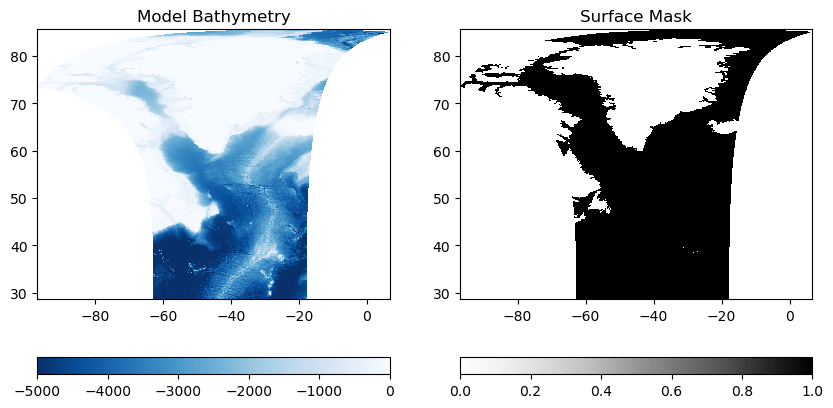

In [17]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

### Step 4: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [43]:
from eccoseas.downscale import horizontal

#### &#x2757; Warning
This code block may take a while to run. Further, it will generate 7 files sized ~500MB. Plan accordingly.

In [53]:
# loop through each variable and corresponding ECCO grid
for year in years:
    exf_grids = exf_year[year]
    for variable_name, exf_grid in zip(variable_names, exf_grids):
    
        # print a message to keep track of which variable we are working on
        # uncomment to use
        print('    - Interpolating the '+variable_name+' grid')
    
        # create a grid of zeros to fill in
        interpolated_grid = np.zeros((np.shape(exf_grid)[0], np.shape(XC)[0], np.shape(XC)[1]))
    
        # loop through each timestep to generate the interpolated grid
        for timestep in range(np.shape(exf_grid)[0]):
    
            # print a message every 100 timesteps to show where we are in the stack
            # uncomment to use
            if timestep%100==0:
                print('        - Working on timestep '+str(timestep)+' of '+str(np.shape(interpolated_grid)[0]))
    
            # grab the values for this timestep and run the interpolation function
            ecco_values = exf_grid[timestep, :, :].ravel()
            interp_timestep = horizontal.downscale_2D_points_with_zeros(ecco_points, ecco_values, ecco_mask,
                                                                        XC, YC, surface_mask)
            interpolated_grid[timestep,:,:] = interp_timestep
    
        # convert ECCO values to MITgcm defaults
        if variable_name=='ATEMP':
            interpolated_grid += 273.15
        if variable_name in ['SWDOWN','LWDOWN']:
            interpolated_grid *=-1
    
        # output the interpolated grid
        output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
        interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ATEMP grid
        - Working on timestep 0 of 1460
        - Working on timestep 100 of 1460
        - Working on timestep 200 of 1460
        - Working on timestep 300 of 1460
        - Working on timestep 400 of 1460
        - Working on timestep 500 of 1460
        - Working on timestep 600 of 1460
        - Working on timestep 700 of 1460
        - Working on timestep 800 of 1460
        - Working on timestep 900 of 1460
        - Working on timestep 1000 of 1460
        - Working on timestep 1100 of 1460
        - Working on timestep 1200 of 1460
        - Working on timestep 1300 of 1460
        - Working on timestep 1400 of 1460
    - Interpolating the SWDOWN grid
        - Working on timestep 0 of 1460
        - Working on timestep 100 of 1460
        - Working on timestep 200 of 1460
        - Working on timestep 300 of 1460
        - Working on timestep 400 of 1460
        - Working on timestep 500 of 1460
        - Working on timestep 600 of 1460
    

!Note: I encountered an out-of-space error during the process so I had to restarted the last 2 files.

### Step 5: Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [30]:
meta_dict = {'ATEMP':[273, 290, cm.thermal, '$^{\\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-6, cm.tempo, 'm/s'],
             'SWDOWN':[-10,20,cm.solar,'W/m$^2$'],
             'LWDOWN':[-100, 500,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-20, 20, cm.balance, 'm/s'],
             'RUNOFF':[0, 2e-8, cm.tempo, 'm/s']}

Then, I'll create all of the subplots:

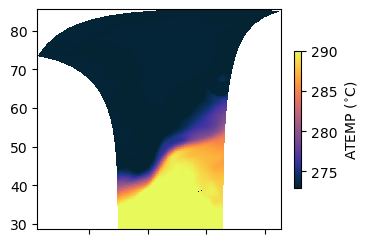

In [31]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    CA_exf_grid = CA_exf_grid.reshape((np.shape(exf_grid)[0],np.shape(XC)[0], np.shape(XC)[1]))

    # choose just the first timestep for plotting
    CA_exf_grid = CA_exf_grid[0, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, CA_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

Looks good! Only one more step and then we're ready to run the model.

I will use data.exf_global file with contents:
```
 &EXF_NML_02
 atempfile         = 'exf/EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
 precipfile        = 'exf/EIG_rain_plus_ECCO_v4r1_ctrl',
 uwindfile         = 'exf/EIG_u10m',
 vwindfile         = 'exf/EIG_v10m',
 swdownfile        = 'exf/EIG_dsw_plus_ECCO_v4r1_ctrl',
 lwdownfile        = 'exf/EIG_dlw_plus_ECCO_v4r1_ctrl',
#
 atempstartdate1   = 20150101,
 atempstartdate2   = 000000,
 atempperiod       = 21600.0,
#
 precipstartdate1  = 20150101,
 precipstartdate2  = 030000,
 precipperiod      = 21600.0,
#
```